In [1]:
%run ../__init__.ipynb

In [2]:
df_pockets = read_pockets()
ubs_uniprot_id = set(df_pockets.query('pocket_is_ubs')['uniprot_id'])
df_pockets = df_pockets.query('uniprot_id in @ubs_uniprot_id').reset_index(drop=True)

In [3]:
cols_ubs = 'pocket_energy', 'pocket_n_points', 'pocket_rad_gyration', 'pocket_energy_per_vol', 'pocket_buriedness', 'pocket_score', 'pocket_pLDDT_mean', 'pocket_score_pLDDT_mean', 'pocket_score_energy', 'pocket_score_combined',
roc_ubs = ROC()
for col in cols_ubs:
    roc_ubs.add(y_true=df_pockets['pocket_is_ubs'], y_score=df_pockets[col], label=col)
roc_ubs.aucs()

metric
pocket_energy              0.820354
pocket_n_points            0.765173
pocket_rad_gyration        0.750966
pocket_energy_per_vol      0.829120
pocket_buriedness          0.832457
pocket_score               0.835758
pocket_pLDDT_mean          0.610753
pocket_score_pLDDT_mean    0.866890
pocket_score_energy        0.869669
pocket_score_combined      0.880245
Name: auc, dtype: float64

In [4]:
df_struct = read_structures().merge(read_evidence(), how='left', left_on='uniprot_id', right_on='accession')\
    .query('(100 <= n_resid) & (n_resid <= 500) & (mean_pLDDT > 70) & (resid_pdb != resid_pdb) & (resid_swiss != resid_swiss)')
df_scores = read_pockets().groupby('struct_id').agg(
    pocket_energy = ('pocket_energy', np.nanmax),
    pocket_n_points = ('pocket_n_points', np.nanmax),
    pocket_rad_gyration = ('pocket_rad_gyration', np.nanmax),
    pocket_energy_per_vol = ('pocket_energy_per_vol', np.nanmax),
    pocket_buriedness = ('pocket_buriedness', np.nanmax),
    pocket_score = ('pocket_score', np.nanmax),
    pocket_pLDDT_mean = ('pocket_pLDDT_mean', np.nanmax),
    pocket_score_pLDDT_mean = ('pocket_score_pLDDT_mean', np.nanmax),
    pocket_score_energy = ('pocket_score_energy', np.nanmax),
    pocket_score_combined = ('pocket_score_combined', np.nanmax),
)
df_struct = df_struct.merge(df_scores, left_on='af2_id', right_on='struct_id', how='left').fillna({'pocket_score_combined_scaled': 0, 'catalytic_activity': False})
#df_struct

cols_ = 'pocket_energy', 'pocket_n_points', 'pocket_rad_gyration', 'pocket_energy_per_vol', 'pocket_buriedness', 'pocket_score', 'pocket_pLDDT_mean', 'pocket_score_pLDDT_mean', 'pocket_score_energy', 'pocket_score_combined',
roc_act = ROC()
for col_ in cols_:
    roc_act.add(y_true=df_struct['catalytic_activity'], y_score=df_struct[col_], label=col_)
roc_act.aucs()

/scratch/tmp.60313377.jjaenes/ipykernel_32935/2467692563.py:3: FutureWarning: The provided callable <function nanmax at 0x2ab5e3c4c700> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_scores = read_pockets().groupby('struct_id').agg(
/scratch/tmp.60313377.jjaenes/ipykernel_32935/2467692563.py:3: FutureWarning: The provided callable <function nanmax at 0x2ab5e3c4c700> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_scores = read_pockets().groupby('struct_id').agg(


metric
pocket_energy              0.757993
pocket_n_points            0.734455
pocket_rad_gyration        0.736370
pocket_energy_per_vol      0.687667
pocket_buriedness          0.683119
pocket_score               0.754381
pocket_pLDDT_mean          0.733757
pocket_score_pLDDT_mean    0.814614
pocket_score_energy        0.772046
pocket_score_combined      0.808926
Name: auc, dtype: float64

barh: pocket_energy 0.820353837314981
barh: pocket_n_points 0.76517347039308
barh: pocket_rad_gyration 0.7509660398537449
barh: pocket_energy_per_vol 0.8291203715491064
barh: pocket_buriedness 0.8324566365529311
barh: pocket_score 0.8357582251899313
barh: pocket_pLDDT_mean 0.6107534928206361
barh: pocket_score_pLDDT_mean 0.8668897429908353
barh: pocket_score_energy 0.8696691105248999
barh: pocket_score_combined 0.8802449872862547
barh: pocket_energy 0.7579934412789505
barh: pocket_n_points 0.73445506251281
barh: pocket_rad_gyration 0.7363701578192252
barh: pocket_energy_per_vol 0.6876665300266447
barh: pocket_buriedness 0.6831189792990366
barh: pocket_score 0.7543810207009634
barh: pocket_pLDDT_mean 0.7337569174011067
barh: pocket_score_pLDDT_mean 0.814613650338184
barh: pocket_score_energy 0.7720460135273622
barh: pocket_score_combined 0.8089260094281615


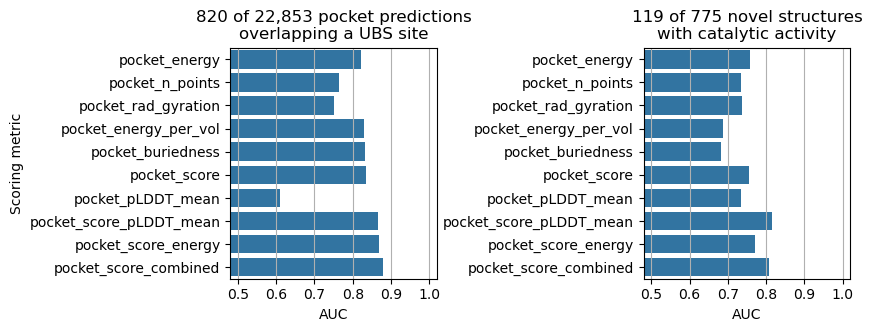

In [9]:
plt.figure(figsize=(8, 3))
plt.subplots_adjust(hspace=0.3, wspace=1)
plt.subplot(1, 2, 1)
plt.title(f'{len(df_pockets.query("pocket_is_ubs"))} of {uf(len(df_pockets))} pocket predictions\noverlapping a UBS site')
roc_ubs.barh(color='tab:blue')
plt.gca().set_ylabel('Scoring metric')

plt.subplot(1, 2, 2)
plt.title(f'{len(df_struct.query("catalytic_activity"))} of {len(df_struct)} novel structures\nwith catalytic activity')
roc_act.barh(color='tab:blue')
plt.gca().set_ylabel('')
plt.savefig('pocket_metrics.svg', bbox_inches='tight', transparent=True)
plt.savefig('pocket_metrics.png', bbox_inches='tight', transparent=True)